# Tutorial: Turn Detection

**Author:** Masoud Abedinifar

**Last update:** Wed 20 Mar. 2024

## Learning Objectives
By the end of this tutorial:
- You can load data from a recording that belongs to one of the available datasets,
- Apply the Pham Turn Detection algorithm.
- Visualize the results of the algorithm.  
- Interpret the detected turns for further analysis.

# Pham Turn Detection

This example can be referenced by citing the package.

The example illustrates how to use PhamTurnDetection algorithm to detect turns using acceleration and gyro data recorded with a lower back IMU sensor. The turn detection algorithm is implemented using [`ngmt.modules.td._pham`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/td/_pham.py). This algorithm is based on the research of Pham et al [`1`].

Describe functionality of the algorithm here...

If requested (plot_results set to True), it generates plots of the accelerometer and gyroscope data along with the detected turns.

#### References
[`1`] Pham et al. (2017). Algorithm for Turning Detection and Analysis Validated under Home-Like Conditions in Patients with Parkinson's Disease and Older Adults using a 6 Degree-of-Freedom Inertial Measurement Unit at the Lower Back. Frontiers in Neurology, 8, 135. https://doi.org/10.3389/fneur.2017.00135

## Import Libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset and PhamTurnDetection turn detection algortihm are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the 'ngmt' library and its dependencies if you haven't already.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngmt.datasets import keepcontrol
from ngmt.modules.td import PhamTurnDetection

## Data Preparation

To implement Pham Turn Detection algorithm, we load example data.


In [3]:
# The 'file_path' variable holds the absolute path to the data file
file_path = (
    r"\\uni-kiel.de\files\bigprojects\neurogeriatrics_data\Keep Control\Data\lab dataset\rawdata\sub-pp002\motion\sub-pp002_task-walkTurn_tracksys-imu_motion.tsv"
)

In [4]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["pelvis"]}

In [5]:
# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    file_name=file_path, tracking_systems=[tracking_sys], tracked_points=tracked_points
)

In [6]:
# Load lower back acceleration data
acceleration_data = recording.data[tracking_sys][
    ["pelvis_ACC_x", "pelvis_ACC_y", "pelvis_ACC_z"]
]

# Print acceleration data
print(f"acceleration_data (g): {acceleration_data}")

acceleration_data (g):       pelvis_ACC_x  pelvis_ACC_y  pelvis_ACC_z
0         0.983901     -0.032714      0.164542
1         0.992177     -0.027832      0.171870
2         0.993660     -0.026852      0.163584
3         0.991220     -0.025391      0.171870
4         0.984858     -0.030754      0.167977
...            ...           ...           ...
7141      0.984380      0.115229      0.228036
7142      0.982897      0.116690      0.218751
7143      0.966298      0.100583      0.217772
7144      0.957019      0.091299      0.211923
7145      0.957019      0.089839      0.211423

[7146 rows x 3 columns]


In [7]:
# Load lower back gyro data
gyro_data = recording.data[tracking_sys][
    ["pelvis_ANGVEL_x", "pelvis_ANGVEL_y", "pelvis_ANGVEL_z"]
]

# Print gyro data
print(f"gyro_data (deg/s): {gyro_data}")

gyro_data (deg/s):       pelvis_ANGVEL_x  pelvis_ANGVEL_y  pelvis_ANGVEL_z
0            0.351765        -0.437449        -0.087013
1           -0.087941        -0.698968         0.174026
2            0.698645        -1.573867        -0.174026
3            0.087941        -1.661039        -0.786015
4            0.874528        -0.611795        -0.350952
...               ...              ...              ...
7141        15.560731       -17.223774        -0.699003
7142        16.699083       -17.310947        -0.261038
7143        18.272255       -17.574051         0.524977
7144        18.970900       -18.185846         1.922982
7145        21.071722       -16.786325         2.534972

[7146 rows x 3 columns]


In [8]:
# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "pelvis_ACC_x"
]["sampling_frequency"].values[0]

# Print sampling frequency
print(f"sampling frequency: {sampling_frequency} Hz")

sampling frequency: 200 Hz


## Visualisation of the Data
The raw acceleration and gyro data including components of x, y and z axis are plotted.

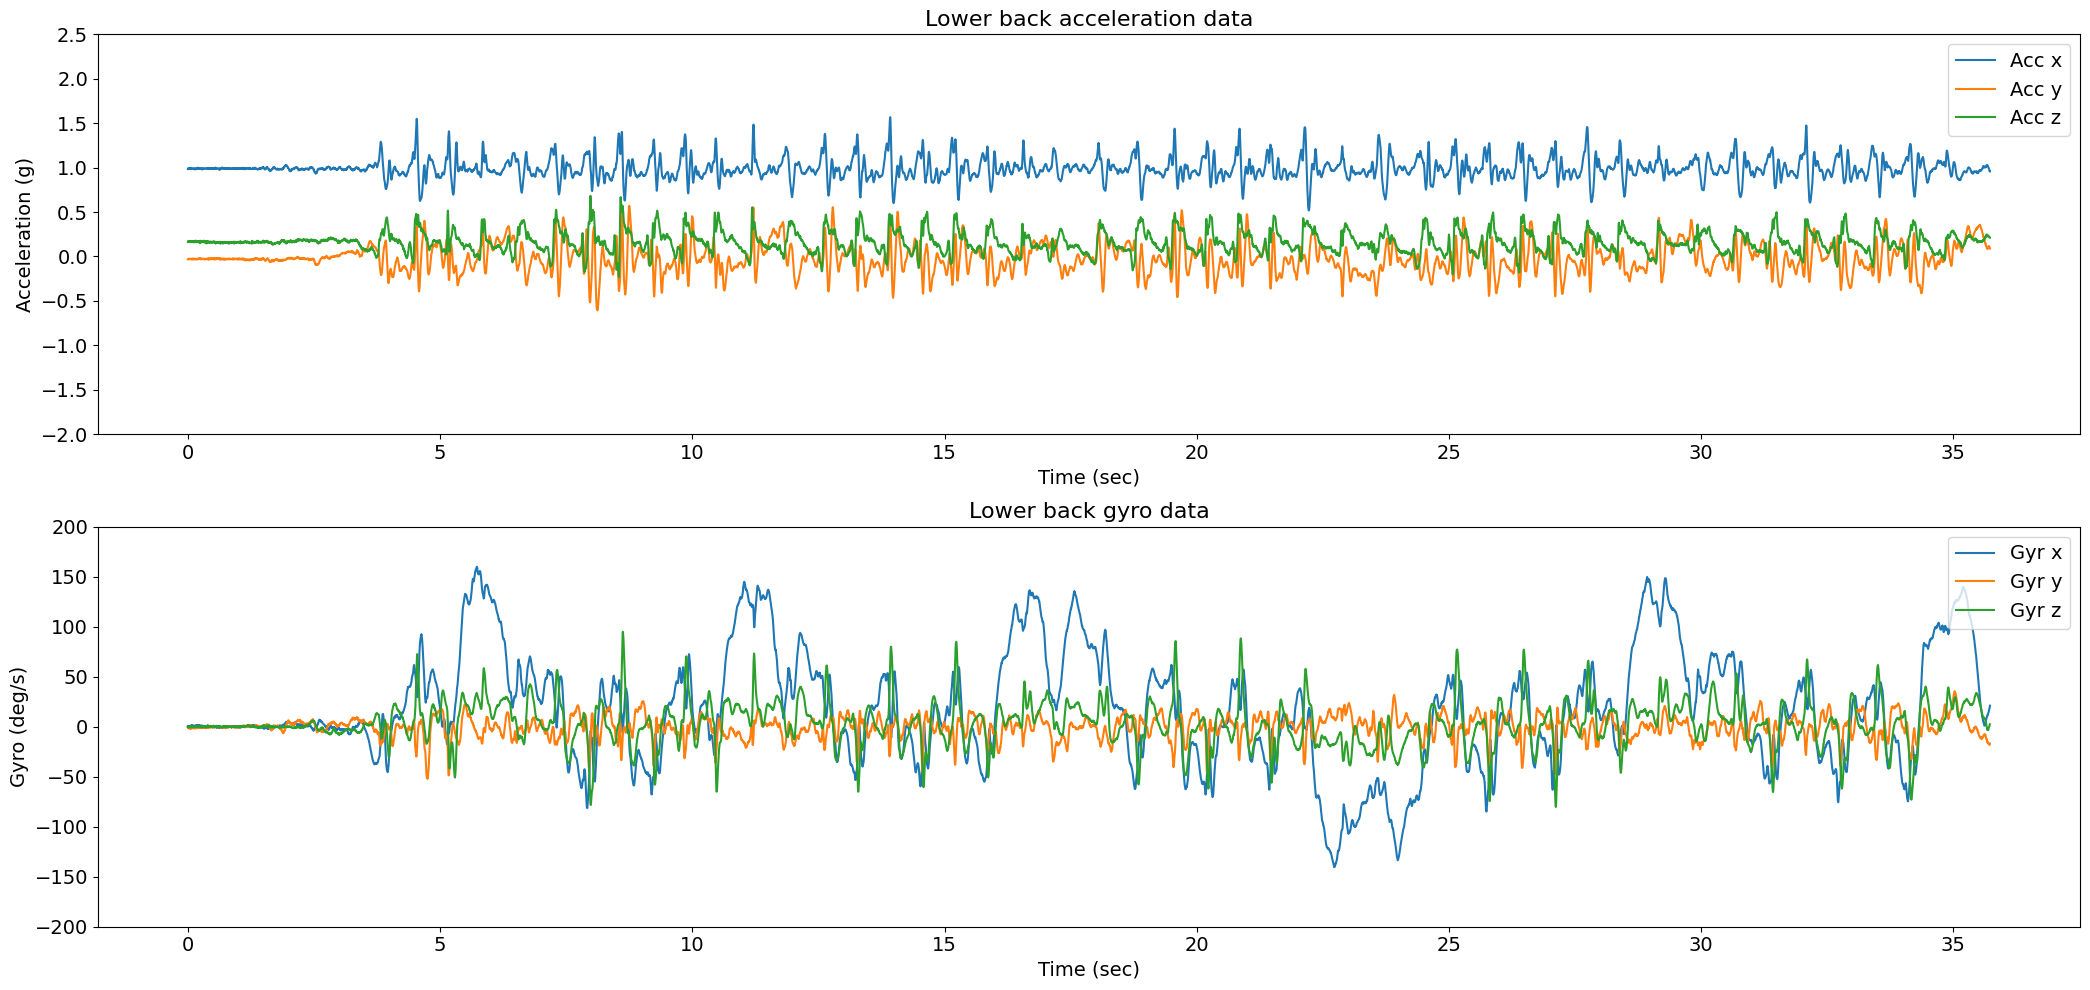

In [13]:
# Plot acceleration and gyro in subplots
fig = plt.figure(figsize=(21, 10))

# Subplot 1: Acceleration data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(acceleration_data)) / sampling_frequency,
        acceleration_data[f"pelvis_ACC_{chr(120 + i)}"],
        label=f"Acc {'xyz'[i]}",
    )
ax1.set_title("Lower back acceleration data", fontsize=16)
ax1.set_ylabel(f"Acceleration (g)", fontsize=14)
ax1.set_xlabel(f"Time (sec)", fontsize=14)
ax1.legend(loc="upper right", fontsize=14)
ax1.set_ylim(-2, 2.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: Gyro data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency,
        gyro_data[f"pelvis_ANGVEL_{chr(120 + i)}"],
        label=f"Gyr {'xyz'[i]}",
    )
ax2.set_title("Lower back gyro data", fontsize=16)
ax2.set_ylabel(f"Gyro (deg/s)", fontsize=14)
ax2.set_xlabel(f"Time (sec)", fontsize=14)
ax2.legend(loc="upper right", fontsize=14)
ax2.set_ylim(-200, 200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
plt.show()


## Applying Pham Turn Detection Algorithm
Now, we are running Pham turn detection algorithm from pham module [`NGMT.ngmt.modules.td._pham.PhamTurnDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/td/_pham.py) to detect turns.

The following code first prepares the input data by combining acceleration and gyro data into a single DataFrame called `input_data`.

Then, in order to apply turn detection algorithm, an instance of the PhamTurnDetection class is created using the constructor, `PhamTurnDetection()`. The `pham` variable holds this instance, allowing us to access its methods. The inputs of the algorithm are as follows:

- **Input Data:** `data` Includes accelerometer and gyro data (N, 6) for x, y, and z axes. in pandas Dataframe format.
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz.
- **Plot Results:** `plot_results`, if set to True, generates a plot showing the detected turns on the data. The default is False. The onset is represented with the vertical red line and the grey area represents the duration of the turns detected by the algorithm.

In [ ]:
# Put acceleration and gyro data in the input data as pandas Dataframe which will be used as input of the algorithm
input_data = [acceleration_data, gyro_data]

# Concatenate acceleration_data and gyro_data along axis=1 (columns)
input_data = pd.concat([acceleration_data, gyro_data], axis=1)

# Create an instance of the PhamTurnDetection class
pham = PhamTurnDetection()

# Call the turn detection using pham.detect
pham = pham.detect(
    data=input_data, sampling_freq_Hz=sampling_frequency, plot_results= True
)

The outputs are stored in the 'detected_turns' attribute, which is a pandas DataFrame in BIDS format with the following columns:

- **onset**: Start of the turn event in seconds.
- **duration**: Duration of the turn event in seconds.
- **tracking_systems**: Tracking system which is 'imu' for this example.
- **tracked_points**: Tracked points on the body which is 'LowerBack' for this example.

In [ ]:
# Print events and their corresponding information
print(f"turn_events: {pham.postural_transitions_}")

## Detailed Visualization of the Detected Turns

To get a better understanding of the results, we can plot the data and the first detected turn. The red vertical line shows the onset and the grey area shows the duration of the first turn.

In [ ]:
# Figure 
fig = plt.figure(figsize=(21, 10))

# Subplot 1: Acceleration data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(acceleration_data)) / sampling_frequency,
        acceleration_data[f"pelvis_ACC_{chr(120 + i)}"],
    )
for i in range(len(pham.postural_transitions_)):
    onset = pham.postural_transitions_['onset'][0]
    duration = pham.postural_transitions_['duration'][0]
    ax1.axvline(x=onset, color='r')
    ax1.axvspan(onset, (onset + duration), color='grey')
ax1.set_title("Detected Turns", fontsize=20)
ax1.set_ylabel(f"Acceleration (g)", fontsize=14)
ax1.set_xlabel(f"Time (sec)", fontsize=14)
ax1.legend(["Acc x", "Acc y", "Acc z", "Turn oset", "Turn duration"], loc="upper right", fontsize=14)
ax1.set_ylim(-1, 2)
start_limit = pham.postural_transitions_["onset"][0] - 10
end_limit = pham.postural_transitions_["onset"][0] + pham.postural_transitions_["duration"][0] + 10
ax1.set_xlim(start_limit, end_limit)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: Gyro data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency,
        gyro_data[f"pelvis_ANGVEL_{chr(120 + i)}"],
    )
for i in range(len(pham.postural_transitions_)):
    onset = pham.postural_transitions_['onset'][0]
    duration = pham.postural_transitions_['duration'][0]
    ax2.axvline(x=onset, color='r')
    ax2.axvspan(onset, (onset + duration), color='grey')
ax1.set_title("Detected Turns", fontsize=20)
ax2.set_ylabel(f"Gyro (deg/s)", fontsize=14)
ax2.set_xlabel(f"Time (sec)", fontsize=14)
start_limit = pham.postural_transitions_["onset"][0] - 10
end_limit = pham.postural_transitions_["onset"][0] + pham.postural_transitions_["duration"][0] + 10
ax2.set_xlim(start_limit, end_limit)
ax2.legend(["Gyr x", "Gyr y", "Gyr z", "Turn onset", "Turn duration"], loc="upper right", fontsize=14)
ax2.set_ylim(-200, 200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
plt.show()